In [1]:
import torch
print(torch.__version__)

torch.backends.cudnn.enabled == True

1.0.0


True

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

2

In [4]:
import torch.nn as nn

In [5]:
PATH = 'data'
PATH_TRAIN = 'data/train'
PATH_TEST = 'data/test'

### Exploring the data

In [6]:
import pandas as pd
from fastai.vision import *

In [7]:
label = pd.read_csv(f'{PATH}/train.csv')

In [8]:
label.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


### Creating 1st Data Object

In [9]:
# Setting transformation parameters

do_flip = True
flip_vert = True
max_rotate = 10.0
max_zoom = 1.05 # not default, but will start smaller

# Creating our transformation object
tfms = get_transforms(do_flip=do_flip, flip_vert=flip_vert, max_rotate=max_rotate, max_zoom=max_zoom)

In [17]:
# Creating our first data object using datablock API

np.random.seed(42)
bs = 128

sz = 64 # 64x64
data = (ImageItemList.from_csv(PATH, 'train.csv', folder='train', suffix='_green.png')
        .random_split_by_pct(0.1)  # 20% will be split into a valid set
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch(bs=bs).normalize(imagenet_stats))

In [10]:
# Setting metrics to measure
acc = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

### Creating 1st Simple model

In [11]:
arch = models.resnet152

In [14]:
# Creating a learner object
learn = create_cnn(data, arch, metrics=[acc, f_score])

In [15]:
if torch.cuda.device_count() > 1:
    learn.model = nn.DataParallel( learn.model )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


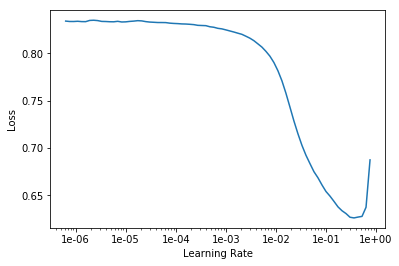

In [22]:
# Finding optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [23]:
# Picking learning rate
lr = 0.03

In [24]:
# 1st training
learn.fit_one_cycle(10, slice(lr), wd=0.10)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.176902,0.227372,0.930422,0.414236
2,0.158063,0.147422,0.935238,0.469979
3,0.157347,0.150682,0.930813,0.467501
4,0.155434,0.150938,0.930388,0.488807
5,0.153946,0.154098,0.934043,0.509014
6,0.150286,0.143722,0.929135,0.522852
7,0.146733,0.138605,0.942112,0.515855
8,0.142683,0.136700,0.936951,0.550138
9,0.139805,0.136862,0.940963,0.551870
10,0.137661,0.136809,0.939721,0.554246


In [32]:
# Testing GPUs
torch.nn.DataParallel(learn.model, device_ids=[0,1])

DataParallel(
  (module): DataParallel(
    (module): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [26]:
# Saving
learn.save('stage-1-64-resnet152-version-3')

In [31]:
learn.load('stage-1-64-resnet152-version-3')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (27965 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: data
x: ImageItemList (27965 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data;

Valid: LabelList
y: MultiCategoryList (3107 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: data
x: ImageItemList (3107 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, di

In [33]:
# Unfreezing layers
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


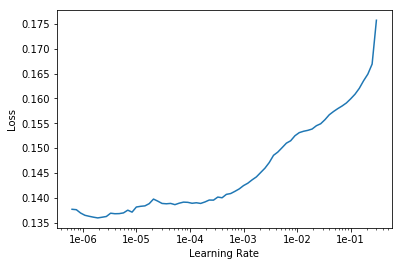

In [28]:
# Finding optimal learning rates
learn.lr_find()
learn.recorder.plot()

In [29]:
# Defining range of learning rates
lr1 = 0.000001
lr2 = 0.0001
lr3 = 0.0005

In [34]:
# 2nd training
learn.fit_one_cycle(10, max_lr=(lr1, lr2, lr3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.137811,0.137820,0.939227,0.553861
2,0.139579,0.133301,0.938503,0.548435
3,0.140745,0.170947,0.938032,0.543360
4,0.139287,0.139346,0.940894,0.550234
5,0.137257,0.138606,0.939170,0.553019
6,0.136741,0.312191,0.937698,0.569994
7,0.134346,0.188717,0.939813,0.572501
8,0.131848,0.200806,0.940618,0.583194
9,0.129699,0.315354,0.940331,0.586683
10,0.129518,0.216787,0.941055,0.589085


In [35]:
# Saving stage 2
learn.save('stage-2-64-resnet152-version-3')

In [46]:
learn.load('stage-2-64-resnet152-version-3')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (27965 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: data
x: ImageItemList (27965 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data;

Valid: LabelList
y: MultiCategoryList (3107 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: data
x: ImageItemList (3107 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, di

### Creating second data object
This time our images will be of size 128x128

In [47]:
# New Data Object
bs = 128

sz = 128 # 128x128
data = (ImageItemList.from_csv(PATH, 'train.csv', folder='train', suffix='_green.png')
        .random_split_by_pct(0.1)  # 20% will be split into a valid set
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch(bs=bs).normalize(imagenet_stats))

learn.data = data

In [48]:
# Freezing all layers
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


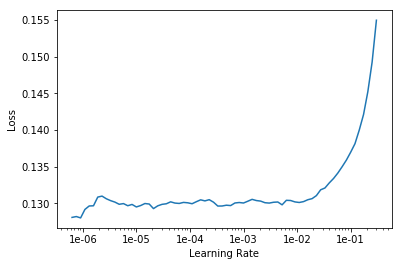

In [38]:
# Finding optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [44]:
# Picking learning rate
lr = 0.007

In [49]:
# 3rd training
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.133256,0.122528,0.943204,0.613225
2,0.126456,0.117580,0.944135,0.638016
3,0.124375,0.127237,0.945952,0.635711
4,0.122724,0.113923,0.944503,0.643192
5,0.120551,0.120960,0.949308,0.647296
6,0.118365,0.116928,0.949986,0.645427
7,0.116180,0.110553,0.947664,0.663908
8,0.114959,0.110599,0.948975,0.663675
9,0.113813,0.110360,0.949480,0.664792
10,0.113105,0.111799,0.949411,0.670434


In [50]:
# Savingm model
learn.save('stage-1-128-resnet152-version-3')

In [51]:
# Unfreezing all layers
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


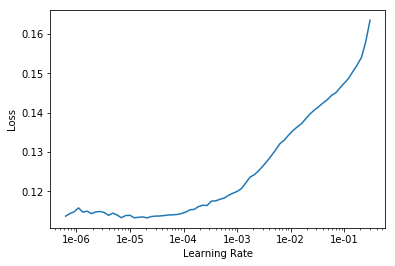

In [52]:
# finding optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [53]:
# Optimal learning rates
lr1 = 0.000001
lr2 = 0.00001
lr3 = 0.0003

In [54]:
# 4th training
learn.fit_one_cycle(10, max_lr=(lr1, lr2, lr3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.113020,0.109094,0.950343,0.667271
2,0.114261,0.114142,0.948492,0.664209
3,0.113782,0.112195,0.949641,0.670229
4,0.113322,0.107223,0.949504,0.667844
5,0.111350,0.110918,0.949745,0.667960
6,0.110883,0.108077,0.949952,0.672766
7,0.110062,0.108654,0.949986,0.676652
8,0.109371,0.120328,0.948641,0.672815
9,0.108407,0.105869,0.949998,0.674453
10,0.108658,0.109820,0.950515,0.675342


In [55]:
learn.save('stage-2-128-resnet152-version-3')

In [17]:
learn.load('stage-2-128-resnet152-version-3')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (27965 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 0]...
Path: data
x: ImageItemList (27965 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data;

Valid: LabelList
y: MultiCategoryList (3107 items)
[MultiCategory 25;3;0, MultiCategory 25;2;0, MultiCategory 7, MultiCategory 5;0, MultiCategory 25;0]...
Path: data
x: ImageItemList (3107 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, 

In [18]:
# Testing GPUs
torch.nn.DataParallel(learn.model, device_ids=[0,1])

DataParallel(
  (module): DataParallel(
    (module): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

### 3rd data object
this time images will be of size 256x256

In [13]:
# New Data Object
# bs = 128

sz = 256 # 256x256
data = (ImageItemList.from_csv(PATH, 'train.csv', folder='train', suffix='_green.png')
        .random_split_by_pct(0.1)  # 20% will be split into a valid set
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch().normalize(imagenet_stats))

In [19]:
learn.data = data

In [20]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


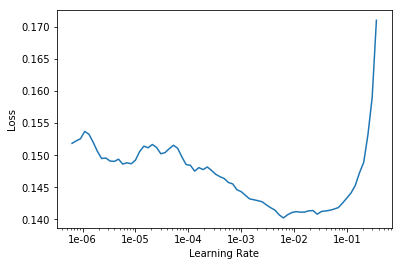

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
# Learning rate
lr = 0.007

In [23]:
# 5th training
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.118595,0.107844,0.950825,0.666375
2,0.114654,0.109302,0.950124,0.679600
3,0.115343,0.105546,0.950112,0.677839
4,0.113613,0.183552,0.948354,0.684020
5,0.110679,0.109192,0.952860,0.695962
6,0.108188,0.099468,0.953239,0.701908
7,0.104574,0.098910,0.956021,0.705376
8,0.101998,0.095344,0.955504,0.719277
9,0.102179,0.094949,0.955998,0.720506
10,0.098938,0.094736,0.956986,0.721419


In [24]:
# Saving model
learn.save('stage-1-256-resnet152-version-3')

In [25]:
# Unfreezing layers
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


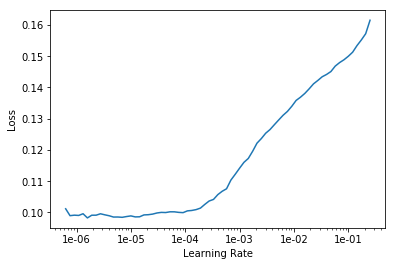

In [26]:
# Findng optimal learning rates
learn.lr_find()
learn.recorder.plot()

In [27]:
# optimal learning rates
lr1 = 0.000001
lr2 = 0.00001
lr3 = 0.0002

In [28]:
# 6th Training
learn.fit_one_cycle(10, max_lr=(lr1, lr2, lr3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.098429,0.094043,0.955964,0.724085
2,0.101942,0.094854,0.956055,0.723348
3,0.102099,0.095648,0.956044,0.720889
4,0.099614,0.093932,0.956872,0.722585
5,0.097947,0.104940,0.954733,0.720951
6,0.097173,0.093435,0.957067,0.725323
7,0.094878,0.093339,0.957596,0.731029
8,0.094403,0.091387,0.957136,0.733615
9,0.095120,0.092296,0.957538,0.733579
10,0.092837,0.091101,0.957228,0.736588


In [29]:
# Saving model
learn.save('stage-2-256-resnet152-version-3')

### 4th data object

sz = 512 # We now increase the size to 512x512

data = (ImageItemList.from_csv(PATH, 'train.csv', folder='train', suffix='_green.png')
        .random_split_by_pct(0.2)  # 20% will be split into a valid set
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch().normalize(imagenet_stats))

learn.data = data

In [58]:
# New Data Object
bs = 32 # Might have to decrease this 

sz = 512 # 128x128
data = (ImageItemList.from_csv(PATH, 'train.csv', folder='train', suffix='_green.png')
        .random_split_by_pct(0.1)  # 20% will be split into a valid set
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .add_test_folder('test')
        .databunch(bs=bs).normalize(imagenet_stats))

# learn.data = data

In [36]:
# Testing GPUs
torch.nn.DataParallel(learn.model, device_ids=[0,1])

DataParallel(
  (module): DataParallel(
    (module): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [37]:
# Freezing layers
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


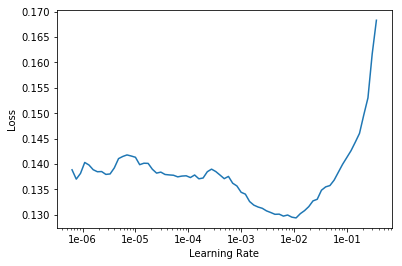

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
# picking learning rate
lr = 0.007

In [41]:
# Training
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.107359,0.490000,0.938331,0.648694
2,0.103312,0.203582,0.952136,0.695105
3,0.111673,0.172855,0.954159,0.670242
4,0.106388,0.178951,0.954584,0.686576
5,0.105002,0.101841,0.956745,0.696105
6,0.100430,0.120409,0.952435,0.721744
7,0.097058,0.096762,0.958228,0.722710
8,0.092720,0.105669,0.957309,0.729933
9,0.091494,0.104075,0.957503,0.733415
10,0.091087,0.134738,0.955986,0.741269


In [42]:
# Saving model
learn.save('stage-1-512-resnet152-version-3a')

In [16]:
learn.load('stage-1-512-resnet152-version-3a')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (27965 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: data
x: ImageItemList (27965 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data;

Valid: LabelList
y: MultiCategoryList (3107 items)
[MultiCategory 5, MultiCategory 3;0, MultiCategory 11, MultiCategory 0, MultiCategory 5;0]...
Path: data
x: ImageItemList (3107 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=

In [17]:
learn.data = data 

In [18]:
# Testing GPUs
torch.nn.DataParallel(learn.model, device_ids=[0,1])

DataParallel(
  (module): DataParallel(
    (module): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


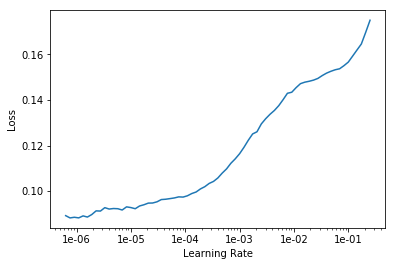

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
lr1 = 0.000001
lr2 = 0.000003
lr3 = 0.00001

In [22]:
learn.fit_one_cycle(10, max_lr=(lr1, lr2, lr3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.090745,0.093801,0.961562,0.758735
2,0.091962,0.138137,0.958148,0.754040
3,0.091758,0.087519,0.962849,0.760813
4,0.088778,0.124997,0.958757,0.745071
5,0.089778,0.157139,0.957952,0.744541
6,0.090027,0.162577,0.957550,0.753064
7,0.088655,0.171491,0.956550,0.752987
8,0.089275,0.116828,0.960527,0.761208
9,0.087765,0.103253,0.961308,0.760248
10,0.087801,0.183175,0.957711,0.755088


In [23]:
learn.save('stage-2-512-resnet152-version-3')

In [ ]:
# Attempting with weight decay

In [25]:
learn.load('stage-1-512-resnet152-version-3a')

learn.data = data

# Enable GPU
torch.nn.DataParallel(learn.model, device_ids=[0,1])

lr1 = 0.000001
lr2 = 0.000003
lr3 = 0.00001


learn.fit_one_cycle(1, max_lr=(lr1, lr2, lr3), wd=0.025)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.091636,0.161467,0.958354,0.757017


In [26]:
learn.save('stage-2-512-resnet152-version3b')

In [27]:
learn.load('stage-1-512-resnet152-version-3a')

learn.data = data

# Enable GPU
torch.nn.DataParallel(learn.model, device_ids=[0,1])

learn.unfreeze()

lr1 = 0.000001
lr2 = 0.000003
lr3 = 0.00001


learn.fit_one_cycle(1, slice(lr1, lr2, lr3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.089381,0.117730,0.960722,0.752040
